In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import warnings

warnings.filterwarnings(
    "ignore",
    message="plotting functions contained within `_documentation_utils` are intended for nemos's documentation.",
    category=UserWarning,
)

warnings.filterwarnings(
    "ignore",
    message="Ignoring cached namespace 'core'",
    category=UserWarning,
)

warnings.filterwarnings(
    "ignore",
    message=(
        "invalid value encountered in div "
    ),
    category=RuntimeWarning,
)

:::{admonition} Download
:class: important render-all

This notebook can be downloaded as **{nb-download}`place_cells.ipynb`**. See the button at the top right to download as markdown or pdf.

:::

# Model and feature selection with scikit-learn

Data for this notebook comes from recordings in the mouse hippocampus while the mouse runs on a linear track. We explored this data [yesterday](../day1/phase_precession.md). Today, we will see that the neurons present in this recording show both tuning for both speed and location (i.e., place fields). However, location and speed are highly correlated. We would like to know which feature is more informative for predicting neuronal firing rate --- how do we do that?

<div class="render-user">
Data for this notebook comes from recordings in the mouse hippocampus while the mouse runs on a linear track, which we [explored yesterday](../day1/phase_precession-users.md).
</div>

<div class="render-all">

## Learning objectives

- Review how to use pynapple to analyze neuronal tuning
- Learn how to combine NeMoS basis objects
- Learn how to use NeMoS objects with [scikit-learn](https://scikit-learn.org/) for cross-validation
- Learn how to use NeMoS objects with scikit-learn [pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
- Learn how to use cross-validation to perform model and feature selection

</div>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pynapple as nap

import nemos as nmo

# some helper plotting functions
from nemos import _documentation_utils as doc_plots
import workshop_utils

# configure plots some
plt.style.use(nmo.styles.plot_style)

import workshop_utils

from sklearn import model_selection
from sklearn import pipeline

# shut down jax to numpy conversion warning
nap.nap_config.suppress_conversion_warnings = True

# during development, set this to a lower number so everything runs faster. 
cv_folds = 5

## Pynapple

<div class="render-user render-presenter">
- Load the data using pynapple.
</div>

In [3]:
path = workshop_utils.fetch_data("Achilles_10252013_EEG.nwb")
data = nap.load_file(path)
data

/home/agent/workspace/rorse_ccn-software-jan-2025_main/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.7.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/agent/workspace/rorse_ccn-software-jan-2025_main/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.4.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Achilles_10252013_EEG
┍━━━━━━━━━━━━━┯━━━━━━━━━━━━━┑
│ Keys        │ Type        │
┝━━━━━━━━━━━━━┿━━━━━━━━━━━━━┥
│ units       │ TsGroup     │
│ rem         │ IntervalSet │
│ nrem        │ IntervalSet │
│ forward_ep  │ IntervalSet │
│ eeg         │ TsdFrame    │
│ theta_phase │ Tsd         │
│ position    │ Tsd         │
┕━━━━━━━━━━━━━┷━━━━━━━━━━━━━┙

<div class="render-user render-presenter">
- Extract the spike times and mouse position.
</div>

In [4]:
spikes = data["units"]
position = data["position"]

For today, we're only going to focus on the times when the animal was traversing the linear track. 
This is a pynapple `IntervalSet`, so we can use it to restrict our other variables:

<div class="render-user render-presenter">

- Restrict data to when animal was traversing the linear track.

</div>

In [5]:
position = position.restrict(data["forward_ep"])
spikes = spikes.restrict(data["forward_ep"])

The recording contains both inhibitory and excitatory neurons. Here we will focus of the excitatory cells with firing above 0.3 Hz.

<div class="render-user render-presenter">

- Restrict neurons to only excitatory neurons, discarding neurons with a low-firing rate.

</div>

In [6]:
spikes = spikes.getby_category("cell_type")["pE"]
spikes = spikes.getby_threshold("rate", 0.3)

### Place fields

By plotting the neuronal firing rate as a function of position, we can see that these neurons are all tuned for position: they fire in a specific location on the track.

<div class="render-user render-presenter">

- Visualize the *place fields*: neuronal firing rate as a function of position.
</div>

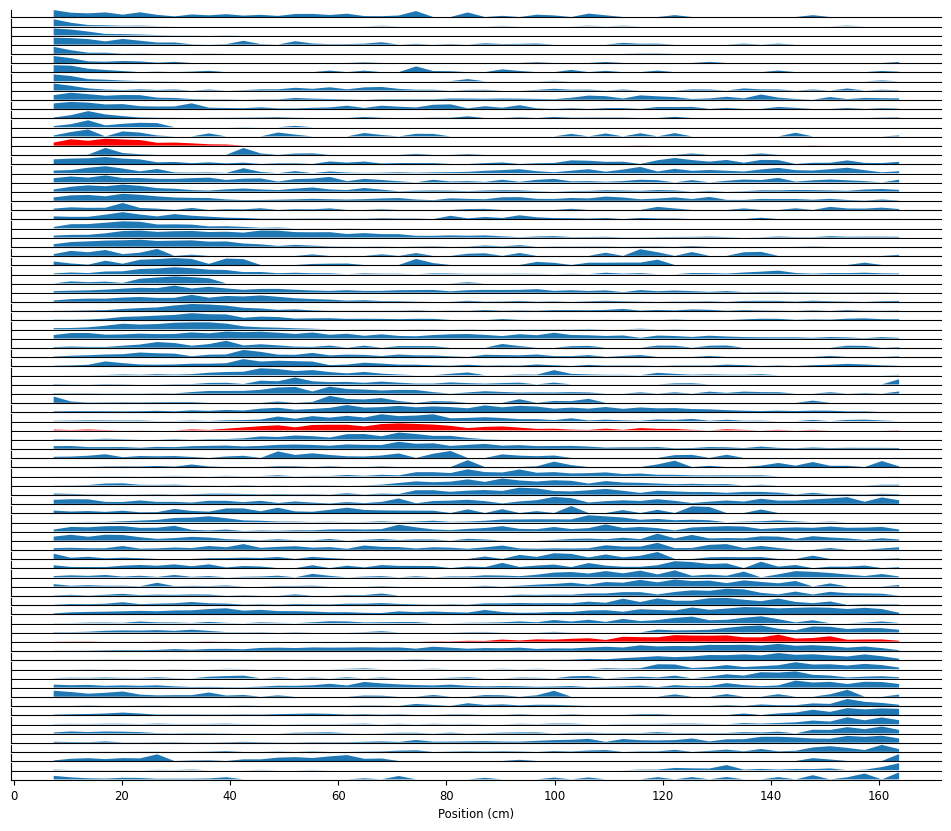

In [7]:
place_fields = nap.compute_1d_tuning_curves(spikes, position, 50, position.time_support)
workshop_utils.plot_place_fields(place_fields)

To decrease computation time, we're going to spend the rest of the notebook focusing on the neurons highlighted above. We're also going to bin spikes at 100 Hz and up-sample the position to match that temporal resolution.

<div class="render-user render-presenter">

- For speed, we're only going to investigate the three neurons highlighted above.
- Bin spikes to counts at 100 Hz.
- Interpolate position to match spike resolution.

</div>

In [8]:
neurons = [82, 92, 220]
place_fields = place_fields[neurons]
spikes = spikes[neurons]
bin_size = .01
count = spikes.count(bin_size, ep=position.time_support)
position = position.interpolate(count, ep=count.time_support)
print(count.shape)
print(position.shape)

(19237, 3)
(19237,)


### Speed modulation


The speed at which the animal traverse the field is not homogeneous. Does it influence the firing rate of hippocampal neurons? We can compute tuning curves for speed as well as average speed across the maze. In the next block, we compute the speed of the animal for each epoch (i.e. crossing of the linear track) by doing the difference of two consecutive position multiplied by the sampling rate of the position.

<div class="render-user render-presenter">

- Compute animal's speed for each epoch.

</div>

In [9]:
speed = []
# Analyzing each epoch separately avoids edge effects.
for s, e in position.time_support.values: 
    pos_ep = position.get(s, e)
    # Absolute difference of two consecutive points
    speed_ep = np.abs(np.diff(pos_ep)) 
    # Padding the edge so that the size is the same as the position/spike counts
    speed_ep = np.pad(speed_ep, [0, 1], mode="edge") 
    # Converting to cm/s 
    speed_ep = speed_ep * position.rate
    speed.append(speed_ep)

speed = nap.Tsd(t=position.t, d=np.hstack(speed), time_support=position.time_support)
print(speed.shape)

(19237,)


Now that we have the speed of the animal, we can compute the tuning curves for speed modulation. Here we call pynapple [`compute_1d_tuning_curves`](https://pynapple.org/generated/pynapple.process.tuning_curves.html#pynapple.process.tuning_curves.compute_1d_tuning_curves):

<div class="render-user render-presenter">

- Compute the tuning curve with pynapple's [`compute_1d_tuning_curves`](https://pynapple.org/generated/pynapple.process.tuning_curves.html#pynapple.process.tuning_curves.compute_1d_tuning_curves)

</div>

In [10]:
tc_speed = nap.compute_1d_tuning_curves(spikes, speed, 20, speed.time_support)

<div class="render-user">

In [ ]:
# compute tuning curve here
tc_speed = 

</div>


<div class="render-user render-presenter">

- Visualize the position and speed tuning for these neurons.
</div>

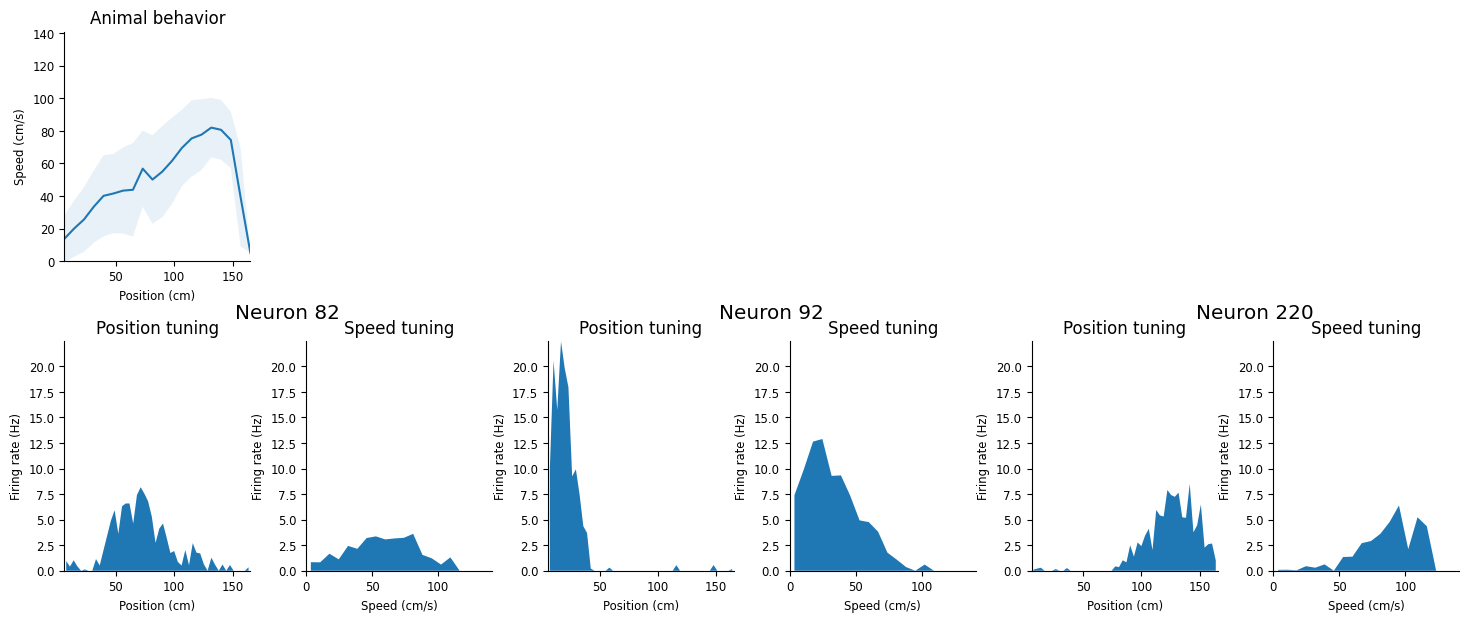

In [11]:
fig = workshop_utils.plot_position_speed(position, speed, place_fields, tc_speed, neurons);

These neurons show a strong modulation of firing rate as a function of speed but we also notice that the animal, on average, accelerates when traversing the field. Is the speed tuning we observe a true modulation or spurious correlation caused by traversing the place field at different speeds? We can use NeMoS to model the activity and give the position and the speed as input variable.

<div class="render-user render-presenter">

These neurons all show both position and speed tuning, and we see that the animal's speed and position are highly correlated. We're going to build a GLM to predict neuronal firing rate -- which variable should we use? Is the speed tuning just epiphenomenal?

</div>

## NeMoS

(basis_eval_place_cells)=
### Basis evaluation

As we've seen before, we will use basis objects to represent the input values.  In previous tutorials, we've used the `Conv` basis objects to represent the time-dependent effects we were looking to capture. Here, we're trying to capture the non-linear relationship between our input variables and firing rate, so we want the `Eval` objects. In these circumstances, you should look at the tuning you're trying to capture and compare to the [basis kernels (visualized in NeMoS docs)](table_basis): you want your tuning to be capturable by a linear combination of them.

In this case, several of these would probably work; we will use [`MSplineEval`](nemos.basis.MSplineEval) for both, though with different numbers of basis functions.

Additionally, since we have two different inputs, we'll need two separate basis objects.

:::{note}

Later in this notebook, we'll show how to cross-validate across basis identity, which you can use to choose the basis.

:::

<div class="render-presenter">

- why basis?
   - without basis:
     - either the GLM says that firing rate increases exponentially as position or speed increases, which is fairly nonsensical,
     - or we have to fit the weight separately for each position or speed, which is really high-dim
   - so, basis allows us to reduce dimensionality, capture non-linear modulation of firing rate (in this case, tuning)
- why eval?
    - basis objects have two modes:
    - conv, like we've seen, for capturing time-dependent effects
    - eval, for capturing non-linear modulation / tuning
- why MSpline?
    - when deciding on eval basis, look at the tuning you want to capture, compare to the kernels: you want your tuning to be capturable by a linear combination of these
    - in cases like this, many possible basis objects we could use here and what I'll show you in a bit will allow you to determine which to use in principled manner
    - MSpline, BSpline, RaisedCosineLinear : all would let you capture this
    - weird choices:
        - cyclic bspline, except maybe for position? if end and start are the same
        - RaisedCosineLog (don't want the stretching)
        - orthogonalized exponential (specialized for...)
        - identity / history (too basic)
</div>


<div class="render-user render-presenter">

- Create a separate basis object for each model input.
- Visualize the basis objects.
</div>

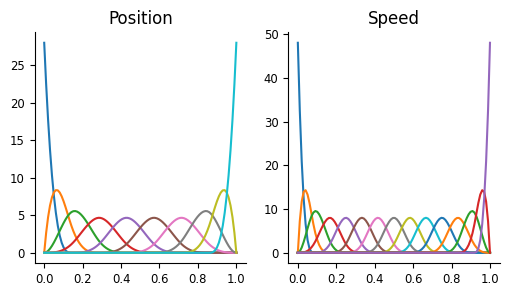

In [12]:
position_basis = nmo.basis.MSplineEval(n_basis_funcs=10)
speed_basis = nmo.basis.MSplineEval(n_basis_funcs=15)
workshop_utils.plot_pos_speed_bases(position_basis, speed_basis)

However, now we have an issue: in all our previous examples, we had a single basis object, which took a single input to produce a single array which we then passed to the `GLM` object as the design matrix. What do we do when we have multiple basis objects?

We could call `basis.compute_features()` for each basis separately and then concatenated the outputs, but then we have to remember the order we concatenated them in and that behavior gets unwieldy as we add more bases.

Instead, NeMoS allows us to combine multiple basis objects into a single "additive basis", which we can pass all of our inputs to in order to produce a single design matrix:

<div class="render-user render-presenter">

- Combine the two basis objects into a single "additive basis"
</div>

In [13]:
# equivalent to calling nmo.basis.AdditiveBasis(position_basis, speed_basis)
basis = position_basis + speed_basis

<div class="render-user render-presenter">

- Create the design matrix!
- Notice that, since we passed the basis pynapple objects, we got one back, preserving the time stamps.
- `X` has the same number of time points as our input position and speed, but 25 columns. The columns come from  `n_basis_funcs` from each basis (10 for position, 15 for speed).

</div>

In [14]:
X = basis.compute_features(position, speed)
X

Time (s)         0        1        2        3    4    ...
---------------  -------  -------  -------  ---  ---  -----
18193.603802655  0.16285  0.0063   5e-05    0.0  0.0  ...
18193.613802655  0.15956  0.0079   9e-05    0.0  0.0  ...
18193.623802655  0.1563   0.00947  0.00012  0.0  0.0  ...
18193.633802655  0.15111  0.01195  0.0002   0.0  0.0  ...
18193.643802655  0.1459   0.0144   0.0003   0.0  0.0  ...
18193.653802655  0.14197  0.01623  0.00039  0.0  0.0  ...
18193.663802655  0.13996  0.01716  0.00045  0.0  0.0  ...
...              ...      ...      ...      ...  ...  ...
20123.332682821  0.0      0.0      0.0      0.0  0.0  ...
20123.342682821  0.0      0.0      0.0      0.0  0.0  ...
20123.352682821  0.0      0.0      0.0      0.0  0.0  ...
20123.362682821  0.0      0.0      0.0      0.0  0.0  ...
20123.372682821  0.0      0.0      0.0      0.0  0.0  ...
20123.382682821  0.0      0.0      0.0      0.0  0.0  ...
20123.392682821  0.0      0.0      0.0      0.0  0.0  ...
dtype: float

### Model learning

As we've done before, we can now use the Poisson GLM from NeMoS to learn the combined model:

<div class="render-user render-presenter">

- Initialize `PopulationGLM`
- Use the "LBFGS" solver and pass `{"tol": 1e-12}` to `solver_kwargs`.
- Fit the data, passing the design matrix and spike counts to the glm object.

</div>

<div class="render-user">

In [ ]:
# initialize 
glm =

# and fit

</div>

In [15]:
glm = nmo.glm.PopulationGLM(
    solver_kwargs={"tol": 1e-12},
    solver_name="LBFGS",
)

glm.fit(X, count)

PopulationGLM(
    observation_model=PoissonObservations(inverse_link_function=exp),
    regularizer=UnRegularized(),
    solver_name='LBFGS',
    solver_kwargs={'tol': 1e-12}
)

### Prediction

Let's check first if our model can accurately predict the tuning curves we displayed above. We can use the [`predict`](nemos.glm.GLM.predict) function of NeMoS and then compute new tuning curves

<div class="render-user render-presenter">

- Use `predict` to check whether our GLM has captured each neuron's speed and position tuning.
- Remember to convert the predicted firing rate to spikes per second!

</div>

<div class="render-user">

In [ ]:
# predict the model's firing rate
predicted_rate = 

# same shape as the counts we were trying to predict
print(predicted_rate.shape, count.shape)

# compute the position and speed tuning curves using the predicted firing rate.
glm_pos = 
glm_speed = 

</div>

In [16]:
# predict the model's firing rate
predicted_rate = glm.predict(X) / bin_size

# same shape as the counts we were trying to predict
print(predicted_rate.shape, count.shape)

# compute the position and speed tuning curves using the predicted firing rate.
glm_pos = nap.compute_1d_tuning_curves_continuous(predicted_rate, position, 50, position.time_support)
glm_speed = nap.compute_1d_tuning_curves_continuous(predicted_rate, speed, 30, speed.time_support)

(19237, 3) (19237, 3)


/home/agent/workspace/rorse_ccn-software-jan-2025_main/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/agent/workspace/rorse_ccn-software-jan-2025_main/lib/python3.11/site-packages/numpy/_core/_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


<div class="render-user render-presenter">

- Compare model and data tuning curves together. The model did a pretty good job!

</div>

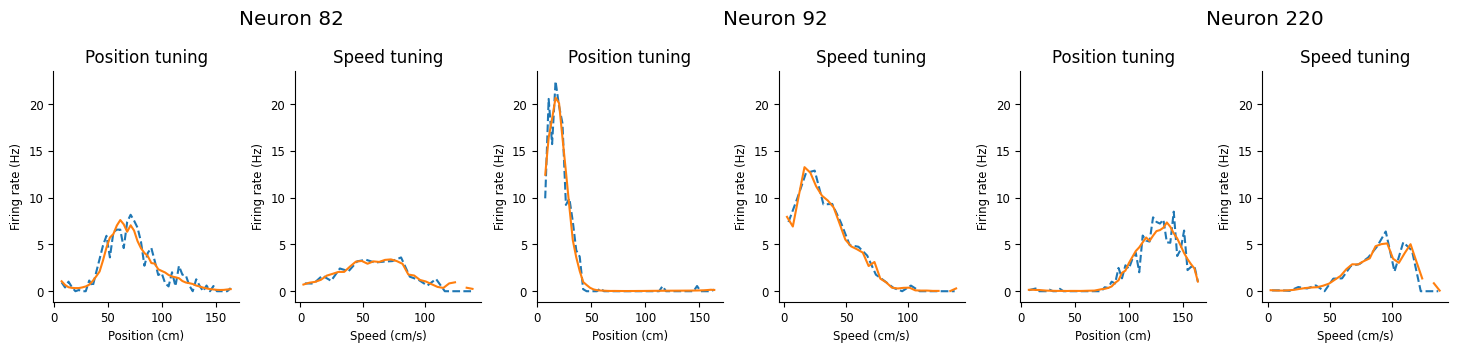

In [17]:
workshop_utils.plot_position_speed_tuning(place_fields, tc_speed, glm_pos, glm_speed);

<div class="render-all">

We can see that this model does a good job capturing both the position and the speed. In the rest of this notebook, we're going to investigate all the scientific decisions that we swept under the rug: should we regularize the model? what basis should we use? do we need both inputs?

To make our lives easier, let's create a helper function that wraps the above
lines, because we're going to be visualizing our model predictions a lot.

</div>

In [18]:
def visualize_model_predictions(glm, X):
    # predict the model's firing rate
    predicted_rate = glm.predict(X) / bin_size

    # compute the position and speed tuning curves using the predicted firing rate.
    glm_pos = nap.compute_1d_tuning_curves_continuous(predicted_rate, position, 50, position.time_support)
    glm_speed = nap.compute_1d_tuning_curves_continuous(predicted_rate, speed, 30, position.time_support)

    workshop_utils.plot_position_speed_tuning(place_fields, tc_speed, glm_pos, glm_speed);

## Scikit-learn

### How to know when to regularize?

In the [last session](./head_direction.md), Edoardo fit the all-to-all connectivity of the head-tuning dataset using the Ridge regularizer. In the model above, we're not using any regularization? Why is that?

We have far fewer parameters here then in the last example. However, how do you know if you need regularization or not? One thing you can do is use cross-validation to see whether model performance improves with regularization (behind the scenes, this is what we did!). We'll walk through how to do that now.

Instead of implementing our own cross-validation machinery, the developers of nemos decided that we should write the package to be compliant with [scikit-learn](https://scikit-learn.org), the canonical machine learning python library. Our models are all what scikit-learn calls "estimators", which means they have `.fit`, `.score.` and `.predict` methods. Thus, we can use them with scikit-learn's objects out of the box.

We're going to use scikit-learn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) object, which performs a cross-validated grid search, as [Edoardo explained in his presentation](https://users.flatironinstitute.org/~wbroderick/presentations/jan-2025/model_selection.pdf).

This object requires an estimator, our `glm` object here, and `param_grid`, a dictionary defining what to check. For now, let's just compare Ridge regularization with no regularization:

<div class="render-user render-presenter">

- How do we decide when to use regularization?
- Cross-validation allows you to fairly compare different models on the same dataset.
- NeMoS makes use of [scikit-learn](https://scikit-learn.org/), the standard machine learning library in python.
- Define [parameter grid](https://scikit-learn.org/stable/modules/grid_search.html#grid-search) to search over.
- Anything not specified in grid will be kept constant.

</div>

In [19]:
param_grid = {
    "regularizer": ["UnRegularized", "Ridge"],
}

<div class="render-user render-presenter">

- Initialize scikit-learn's [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) object.
</div>

In [20]:
cv = model_selection.GridSearchCV(glm, param_grid, cv=cv_folds)
cv

GridSearchCV(cv=5,
             estimator=PopulationGLM(
    observation_model=PoissonObservations(inverse_link_function=exp),
    regularizer=UnRegularized(),
    solver_name='LBFGS',
    solver_kwargs={'tol': 1e-12}
),
             param_grid={'regularizer': ['UnRegularized', 'Ridge']})

This will take a bit to run, because we're fitting the model many times!

<div class="render-user render-presenter">

- We interact with this in a very similar way to the glm object.
- In particular, call `fit` with same arguments:
</div>

In [21]:
cv.fit(X, count)

/home/agent/workspace/rorse_ccn-software-jan-2025_main/lib/python3.11/site-packages/nemos/base_regressor.py:193: UserWarning: Caution: regularizer strength has not been set. Defaulting to 1.0. Please see the documentation for best practices in setting regularization strength.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-jan-2025_main/lib/python3.11/site-packages/nemos/base_regressor.py:193: UserWarning: Caution: regularizer strength has not been set. Defaulting to 1.0. Please see the documentation for best practices in setting regularization strength.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-jan-2025_main/lib/python3.11/site-packages/nemos/base_regressor.py:193: UserWarning: Caution: regularizer strength has not been set. Defaulting to 1.0. Please see the documentation for best practices in setting regularization strength.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-jan-2025_main/lib/python3.11/site-packages/nemos/base_regressor.py:193: UserWarning: Caution: regularizer strength has not been set. Defaulting to 1.0. Please see the documentation for best practices in setting regularization strength.
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-jan-2025_main/lib/python3.11/site-packages/nemos/base_regressor.py:193: UserWarning: Caution: regularizer strength has not been set. Defaulting to 1.0. Please see the documentation for best practices in setting regularization strength.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=PopulationGLM(
    observation_model=PoissonObservations(inverse_link_function=exp),
    regularizer=UnRegularized(),
    solver_name='LBFGS',
    solver_kwargs={'tol': 1e-12}
),
             param_grid={'regularizer': ['UnRegularized', 'Ridge']})

<div class="render-user render-presenter">

- We got a warning because we didn't specify the regularizer strength, so we just fell back on default value.
- Let's investigate results:
</div>

Cross-validation results are stored in a dictionary attribute called `cv_results_`, which contains a lot of info.

In [22]:
cv.cv_results_

{'mean_fit_time': array([2.34017291, 2.00892472]),
 'std_fit_time': array([0.42876242, 0.1954901 ]),
 'mean_score_time': array([0.18504963, 0.00365276]),
 'std_score_time': array([0.22262815, 0.00041068]),
 'param_regularizer': masked_array(data=['UnRegularized', 'Ridge'],
              mask=[False, False],
        fill_value=np.str_('?'),
             dtype=object),
 'params': [{'regularizer': 'UnRegularized'}, {'regularizer': 'Ridge'}],
 'split0_test_score': array([-0.11310252, -0.13712785]),
 'split1_test_score': array([-0.10429042, -0.12844072]),
 'split2_test_score': array([-0.13868614, -0.17322585]),
 'split3_test_score': array([-0.11728746, -0.13869132]),
 'split4_test_score': array([-0.11506688, -0.1312802 ]),
 'mean_test_score': array([-0.11768668, -0.14175319]),
 'std_test_score': array([0.01138836, 0.01617531]),
 'rank_test_score': array([1, 2], dtype=int32)}

The most informative for us is the `'mean_test_score'` key, which shows the average of `glm.score` on each test-fold. Thus, higher is better, and we can see that the UnRegularized model performs better.

<div class="render-all">

:::{note}
You could (and generally, should!) investigate `regularizer_strength`, but we're skipping for simplicity. To do this properly, use a slightly different syntax for `param_grid` (list of dictionaries, instead of single dictionary)

```python
param_grid = [
    {"regularizer": [nmo.regularizer.UnRegularized()]},
    {"regularizer": [nmo.regularizer.Ridge()],
     "regularizer_strength": [1e-6, 1e-3, 1]}
]
```
:::

</div>

### Select basis

We can do something similar to select the basis. In the above example, I just told you which basis function to use and how many of each. But, in general, you want to select those in a reasonable manner. Cross-validation to the rescue!

Unlike the glm objects, our basis objects are not scikit-learn compatible right out of the box. However, they can be made compatible by using the `.to_transformer()` method (or, equivalently, by using the `TransformerBasis` class)

<div class="render-user render-presenter">

- You can (and should) do something similar to determine how many basis functions you need for each input.
- NeMoS basis objects are not scikit-learn-compatible right out of the box.
- But we have provided a simple method to make them so:

</div>

In [23]:
position_basis = nmo.basis.MSplineEval(n_basis_funcs=10).to_transformer()
# or equivalently:
position_basis = nmo.basis.TransformerBasis(nmo.basis.MSplineEval(n_basis_funcs=10))

This gives the basis object the `transform` method, which is equivalent to `compute_features`. However, transformers have some limits:

<div class="render-user render-presenter">

- This gives the basis object the `transform` method, which is equivalent to `compute_features`.
- However, transformers have some limits:

</div>

In [24]:
position_basis.transform(position)

RuntimeError: Cannot apply TransformerBasis: the provided basis has no defined input shape. Please call `set_input_shape` before calling `fit`, `transform`, or `fit_transform`.

<div class="render-user render-presenter">

- Transformers only accept 2d inputs, whereas nemos basis objects can accept inputs of any dimensionality.
- In order to tell nemos how to reshape the 2d matrix that is the input of `transform` to whatever the basis accepts, you need to call `set_input_shape`:

</div>

Transformers only accept 2d inputs, whereas nemos basis objects can accept inputs of any dimensionality. In order to tell nemos how to reshape the 2d matrix that is the input of `transform` to whatever the basis accepts, you need to call `set_input_shape`:

In [25]:
# can accept array
position_basis.set_input_shape(position)
# int
position_basis.set_input_shape(1)
# tuple
position_basis.set_input_shape(position.shape[1:])

Transformer(MSplineEval(n_basis_funcs=10, order=4))

<div class="render-user render-presenter">

- Then you can call transform on the 2d input as expected.
</div>

In [26]:
# input needs to be 2d, so use expand_dims
position_basis.transform(np.expand_dims(position, 1))

Time (s)         0        1        2        3    4    ...
---------------  -------  -------  -------  ---  ---  -----
18193.603802655  0.16285  0.0063   5e-05    0.0  0.0  ...
18193.613802655  0.15956  0.0079   9e-05    0.0  0.0  ...
18193.623802655  0.1563   0.00947  0.00012  0.0  0.0  ...
18193.633802655  0.15111  0.01195  0.0002   0.0  0.0  ...
18193.643802655  0.1459   0.0144   0.0003   0.0  0.0  ...
18193.653802655  0.14197  0.01623  0.00039  0.0  0.0  ...
18193.663802655  0.13996  0.01716  0.00045  0.0  0.0  ...
...              ...      ...      ...      ...  ...  ...
20123.332682821  0.0      0.0      0.0      0.0  0.0  ...
20123.342682821  0.0      0.0      0.0      0.0  0.0  ...
20123.352682821  0.0      0.0      0.0      0.0  0.0  ...
20123.362682821  0.0      0.0      0.0      0.0  0.0  ...
20123.372682821  0.0      0.0      0.0      0.0  0.0  ...
20123.382682821  0.0      0.0      0.0      0.0  0.0  ...
20123.392682821  0.0      0.0      0.0      0.0  0.0  ...
dtype: float

<div class="render-all">

- You can, equivalently, call `compute_features` *before* turning the basis into a transformer. Then we cache the shape for future use:

</div>

In [27]:
position_basis = nmo.basis.MSplineEval(n_basis_funcs=10)
position_basis.compute_features(position)
position_basis = position_basis.to_transformer()
speed_basis = nmo.basis.MSplineEval(n_basis_funcs=15).to_transformer().set_input_shape(1)
basis = position_basis + speed_basis

Let's create a single TsdFrame to hold all our inputs:

<div class="render-user render-presenter">

- Create a single TsdFrame to hold all our inputs:
</div>

In [28]:
transformer_input = nap.TsdFrame(
    t=position.t,
    d=np.stack([position.d, speed.d], 1),
    time_support=position.time_support,
    columns=["position", "speed"],
)

<div class="render-user render-presenter">

- Pass this input to our transformed additive basis:
</div>

Our new additive transformer basis can then take these behavioral inputs and turn them into the model's design matrix.

In [29]:
basis.transform(transformer_input)

Time (s)         0        1        2        3    4    ...
---------------  -------  -------  -------  ---  ---  -----
18193.603802655  0.16285  0.0063   5e-05    0.0  0.0  ...
18193.613802655  0.15956  0.0079   9e-05    0.0  0.0  ...
18193.623802655  0.1563   0.00947  0.00012  0.0  0.0  ...
18193.633802655  0.15111  0.01195  0.0002   0.0  0.0  ...
18193.643802655  0.1459   0.0144   0.0003   0.0  0.0  ...
18193.653802655  0.14197  0.01623  0.00039  0.0  0.0  ...
18193.663802655  0.13996  0.01716  0.00045  0.0  0.0  ...
...              ...      ...      ...      ...  ...  ...
20123.332682821  0.0      0.0      0.0      0.0  0.0  ...
20123.342682821  0.0      0.0      0.0      0.0  0.0  ...
20123.352682821  0.0      0.0      0.0      0.0  0.0  ...
20123.362682821  0.0      0.0      0.0      0.0  0.0  ...
20123.372682821  0.0      0.0      0.0      0.0  0.0  ...
20123.382682821  0.0      0.0      0.0      0.0  0.0  ...
20123.392682821  0.0      0.0      0.0      0.0  0.0  ...
dtype: float

### Pipelines

We need one more step: scikit-learn cross-validation operates on an estimator, like our GLMs. if we want to cross-validate over the basis or its features, we need to combine our transformer basis with the estimator into a single estimator object. Luckily, scikit-learn provides tools for this: pipelines.

Pipelines are objects that accept a series of (0 or more) transformers, culminating in a final estimator. This is defined as a list of tuples, with each tuple containing a human-readable label and the object itself:

<div class="render-user render-presenter">

- If we want to cross-validate over the basis, we need more one more step: combining the basis and the GLM into a single scikit-learn estimator.
- [Pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to the rescue!

</div>

In [30]:
pipe = pipeline.Pipeline([
    ("basis", basis),
    ("glm", glm)
])
pipe

Pipeline(steps=[('basis',
                 Transformer(AdditiveBasis(
    basis1=MSplineEval(n_basis_funcs=10, order=4),
    basis2=MSplineEval(n_basis_funcs=15, order=4),
))),
                ('glm',
                 PopulationGLM(
    observation_model=PoissonObservations(inverse_link_function=exp),
    regularizer=UnRegularized(),
    solver_name='LBFGS',
    solver_kwargs={'tol': 1e-12}
))])

This pipeline object allows us to e.g., call fit using the *initial input*:

<div class="render-user render-presenter">

- Pipeline runs `basis.transform`, then passes that output to `glm`, so we can do everything in a single line:
</div>

In [31]:
pipe.fit(transformer_input, count)

Pipeline(steps=[('basis',
                 Transformer(AdditiveBasis(
    basis1=MSplineEval(n_basis_funcs=10, order=4),
    basis2=MSplineEval(n_basis_funcs=15, order=4),
))),
                ('glm',
                 PopulationGLM(
    observation_model=PoissonObservations(inverse_link_function=exp),
    regularizer=UnRegularized(),
    solver_name='LBFGS',
    solver_kwargs={'tol': 1e-12}
))])

We then visualize the predictions the same as before, using `pipe` instead of `glm`.

<div class="render-user render-presenter">

- Visualize model predictions!

</div>

/home/agent/workspace/rorse_ccn-software-jan-2025_main/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/agent/workspace/rorse_ccn-software-jan-2025_main/lib/python3.11/site-packages/numpy/_core/_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


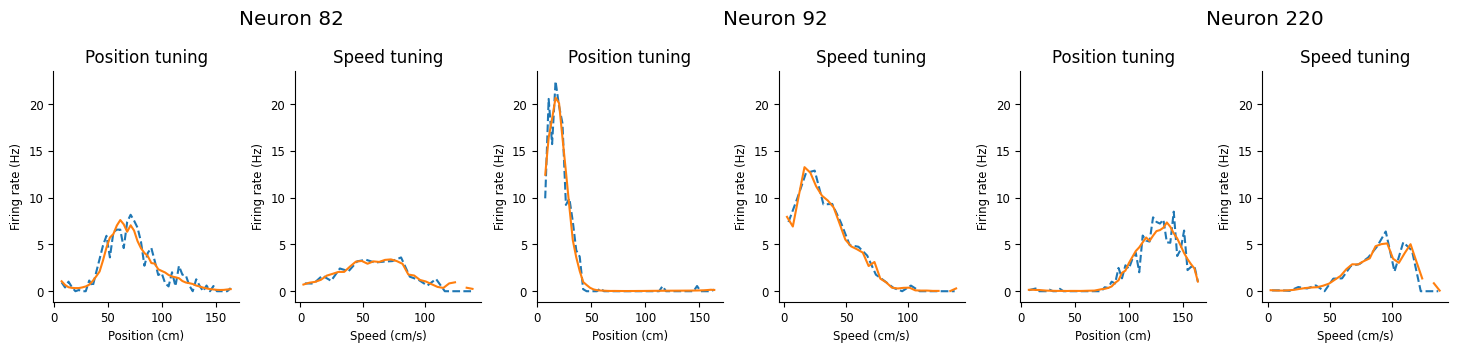

In [32]:
visualize_model_predictions(pipe, transformer_input)

### Cross-validating on the basis

<div class="render-all">

Now that we have our pipeline estimator, we can cross-validate on any of its parameters!

</div>

In [33]:
pipe.steps

[('basis',
  Transformer(AdditiveBasis(
      basis1=MSplineEval(n_basis_funcs=10, order=4),
      basis2=MSplineEval(n_basis_funcs=15, order=4),
  ))),
 ('glm',
  PopulationGLM(
      observation_model=PoissonObservations(inverse_link_function=exp),
      regularizer=UnRegularized(),
      solver_name='LBFGS',
      solver_kwargs={'tol': 1e-12}
  ))]

Let's cross-validate on the number of basis functions for the position basis, and the identity of the basis for the speed. That is:

<div class="render-user render-presenter">

Let's cross-validate on:
- The number of the basis functions of the position basis
- The functional form of the basis for speed
</div>

In [34]:
print(pipe["basis"].basis1.n_basis_funcs)
print(pipe["basis"].basis2)

10
MSplineEval(n_basis_funcs=15, order=4)


For scikit-learn parameter grids, we use `__` to stand in for `.`:

<div class="render-user render-presenter">

- Construct `param_grid`, using `__` to stand in for `.`
</div>

In [35]:
param_grid = {
    "basis__basis1__n_basis_funcs": [5, 10, 20],
    "basis__basis2": [nmo.basis.MSplineEval(15).set_input_shape(1),
                      nmo.basis.BSplineEval(15).set_input_shape(1),
                      nmo.basis.RaisedCosineLinearEval(15).set_input_shape(1)],
}

<div class="render-user render-presenter">

- Cross-validate as before:
</div>

In [36]:
cv = model_selection.GridSearchCV(pipe, param_grid, cv=cv_folds)
cv.fit(transformer_input, count)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('basis',
                                        Transformer(AdditiveBasis(
    basis1=MSplineEval(n_basis_funcs=10, order=4),
    basis2=MSplineEval(n_basis_funcs=15, order=4),
))),
                                       ('glm',
                                        PopulationGLM(
    observation_model=PoissonObservations(inverse_link_function=exp),
    regularizer=UnRegularized(),
    solver_name='LBFGS',
    solver_kwargs={'tol': 1e-12}
))]),
             param_grid={'basis__basis1__n_basis_funcs': [5, 10, 20],
                         'basis__basis2': [MSplineEval(n_basis_funcs=15, order=4),
                                           BSplineEval(n_basis_funcs=15, order=4),
                                           RaisedCosineLinearEval(n_basis_funcs=15, width=2.0)]})

<div class="render-user render-presenter">

- Investigate results:
</div>

In [37]:
cv.cv_results_

{'mean_fit_time': array([2.25496011, 2.06054902, 1.93702583, 2.24597082, 2.02171369,
        2.05452781, 2.47868872, 2.08874574, 2.0526113 ]),
 'std_fit_time': array([0.20833639, 0.19211488, 0.02637091, 0.33353135, 0.03261614,
        0.01772588, 0.52639498, 0.03918542, 0.03373442]),
 'mean_score_time': array([0.13341117, 0.01664338, 0.01528554, 0.01864305, 0.0176085 ,
        0.01839328, 0.09043288, 0.0239346 , 0.02581434]),
 'std_score_time': array([0.14495445, 0.00114055, 0.00146928, 0.00105054, 0.00068218,
        0.00166267, 0.08465981, 0.00059833, 0.00409685]),
 'param_basis__basis1__n_basis_funcs': masked_array(data=[5, 5, 5, 10, 10, 10, 20, 20, 20],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value=999999),
 'param_basis__basis2': masked_array(data=[MSplineEval(n_basis_funcs=15, order=4),
                    BSplineEval(n_basis_funcs=15, order=4),
                    RaisedCosineLinearEval(n_basis_funcs=15

Now that our `param_grid` is more complex, our results dictionary has gotten harder to understand. Let's convert it to a [pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) to make it a bit easier to understand.

We can also make use of a helper function to create a summary heatmap.

:::{note}

[pandas](https://pandas.pydata.org/) is a very helpful python library for representing and analyzing structured data. If you are unfamiliar with pandas, [Jake VanderPlas's Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) contains a [good introduction](https://jakevdp.github.io/PythonDataScienceHandbook/03.01-introducing-pandas-objects.html).

:::

<div class="render-user render-presenter">

- These results are more complicated, so let's use [pandas dataframe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) to make them a bit more understandable:
</div>

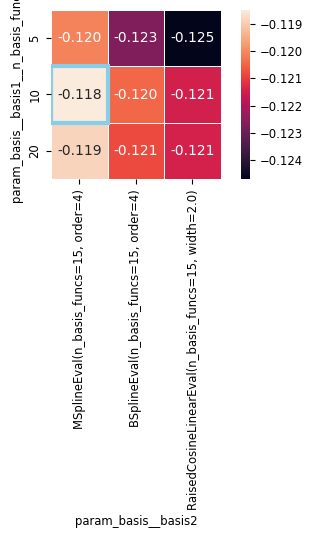

In [38]:
cv_df = pd.DataFrame(cv.cv_results_)
cv_df
# helper function for visualization
workshop_utils.plot_heatmap_cv_results(cv_df)

scikit-learn does not cache every model that it runs (that could get prohibitively large!), but it does store the best estimator, as the appropriately-named `best_estimator_`.

<div class="render-user render-presenter">

- Can easily grab the best estimator, the pipeline that did the best:
</div>

In [39]:
best_estim = cv.best_estimator_
best_estim

Pipeline(steps=[('basis',
                 Transformer(AdditiveBasis(
    basis1=MSplineEval(n_basis_funcs=10, order=4),
    basis2=MSplineEval(n_basis_funcs=15, order=4),
))),
                ('glm',
                 PopulationGLM(
    observation_model=PoissonObservations(inverse_link_function=exp),
    regularizer=UnRegularized(),
    solver_name='LBFGS',
    solver_kwargs={'tol': 1e-12}
))])

We then visualize the predictions of `best_estim` the same as before.

<div class="render-user render-presenter">

- Visualize model predictions!

</div>

/home/agent/workspace/rorse_ccn-software-jan-2025_main/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/agent/workspace/rorse_ccn-software-jan-2025_main/lib/python3.11/site-packages/numpy/_core/_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


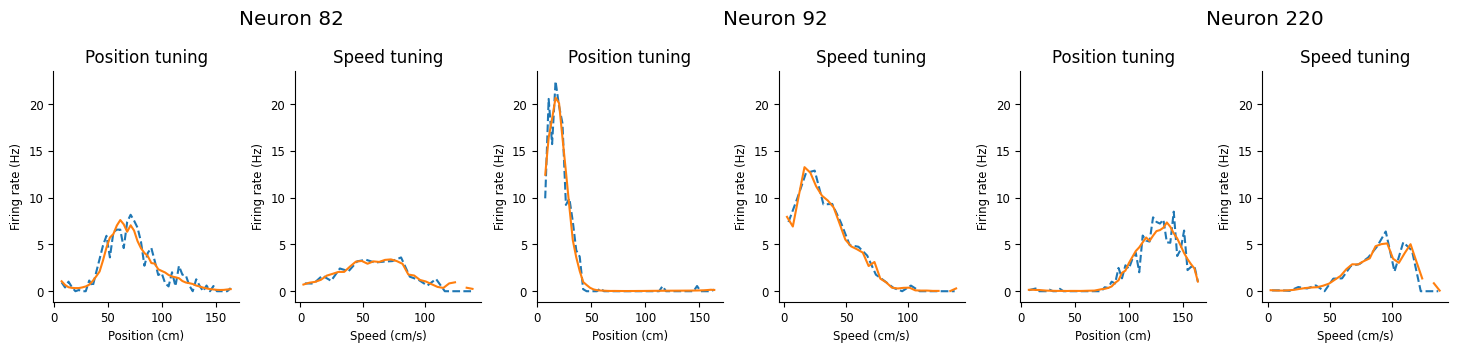

In [40]:
visualize_model_predictions(best_estim, transformer_input)

### Feature selection

Now, finally, we understand almost enough about how scikit-learn works to figure out whether both position and speed are necessary inputs, i.e., to do feature selection. There's just one more thing to learn: feature masks.

Each `PopulationGLM` object has a feature mask attribute, which allows us to exclude certain parts of the input. Its shape is `X.shape[1]` (number of columns in the design matrix) by `n_neurons` (number of neurons we're trying to predict) and, if it's not specified explicitly, a default mask including everything is created:

<div class="render-user render-presenter">

- Now one more thing we can do with scikit-learn!
- Each `PopulationGLM` object has a feature mask, which allows us to exclude certain parts of the input
- Feature mask shape: `X.shape[1]` (number of columns in the design matrix) by `n_neurons` (number of neurons we're trying to predict)
- (By default, everything is included.)
</div>

In [41]:
pipe['glm'].feature_mask
print(pipe['glm'].feature_mask.shape)

(25, 3)


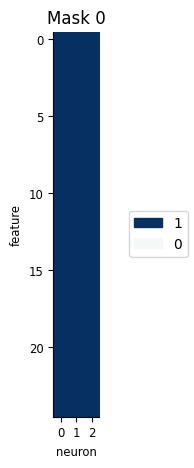

In [42]:
workshop_utils.plot_feature_mask(pipe["glm"].feature_mask);

We could manually edit feature mask the feature mask, but we have some helper functions to help easily create them:

<div class="render-user render-presenter">
- We could manually edit feature mask, but have some helper functions -- these are currently being developed, so any feedback is appreciated!
- By default, we include all features:

</div>

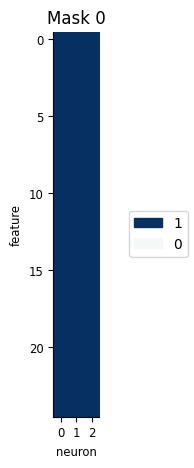

In [43]:
m = workshop_utils.create_feature_mask(pipe["basis"], n_neurons=count.shape[1])
workshop_utils.plot_feature_mask(m);

This function makes use of our additive basis to figure out the structure in the input and allows us to selectively remove some of the features:

<div class="render-user render-presenter">

- Make use of our additive basis to figure out the structure in the input
- Can selectively remove some of the features:
</div>

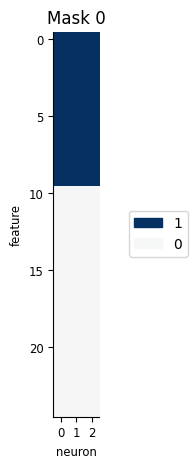

In [44]:
m = workshop_utils.create_feature_mask(pipe["basis"], ["all", "none"], n_neurons=count.shape[1])
fig=workshop_utils.plot_feature_mask(m);

To perform feature selection, we'll want to compare three masks: one including all inputs, one including just the position inputs, and one including just the speed inputs.

<div class="render-user render-presenter">

- Can construct a set of feature masks that includes / excludes each of the sets of inputs:
</div>

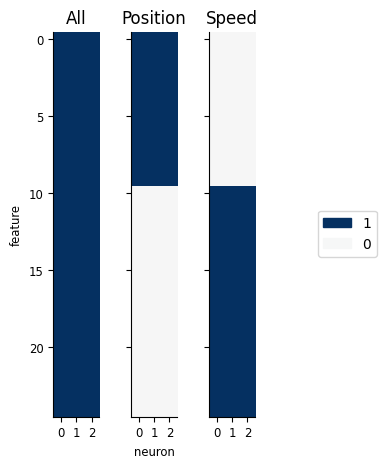

In [45]:
feature_masks = [
    workshop_utils.create_feature_mask(basis, "all", n_neurons=count.shape[1]),
    workshop_utils.create_feature_mask(basis, ["all", "none"], n_neurons=count.shape[1]),
    workshop_utils.create_feature_mask(basis, ["none", "all"], n_neurons=count.shape[1]),
]

workshop_utils.plot_feature_mask(feature_masks, ["All", "Position", "Speed"]);

One more wrinkle: the shape of this feature mask depends on the number of basis functions! (The number of features is `basis.n_basis_funcs = basis.basis1.n_basis_funcs + basis.basis2.n_basis_funcs`.) Thus we need to create a new feature mask for each possible arrangement. We do this in a helper function as well:

<div class="render-user render-presenter">

- One more wrinkle: the shape of this feature mask depends on the number of basis functions!
- Thus, must create a new feature mask for each possible arrangement:
</div>

In [46]:
param_grid = workshop_utils.create_feature_mask_paramgrid(basis, [5, 10, 20], 
                                                          [8, 16, 32], count.shape[1])

Now, as before, initialize and fit `GridSearchCV`:

<div class="render-user render-presenter">

- Initialize and fit GridSearchCV
</div>

In [47]:
cv = model_selection.GridSearchCV(best_estim, param_grid, cv=cv_folds)
cv.fit(transformer_input, count)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('basis',
                                        Transformer(AdditiveBasis(
    basis1=MSplineEval(n_basis_funcs=10, order=4),
    basis2=MSplineEval(n_basis_funcs=15, order=4),
))),
                                       ('glm',
                                        PopulationGLM(
    observation_model=PoissonObservations(inverse_link_function=exp),
    regularizer=UnRegularized(),
    solver_name='LBFGS',
    solver_kwargs={'tol': 1e-12}
))]),
             param_grid=...
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])]}])

And examine the results:

<div class="render-user render-presenter">

- Investigate results using pandas
</div>

In [48]:
cv_df = pd.DataFrame(cv.cv_results_)
cv_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_basis__basis1__n_basis_funcs,param_basis__basis2__n_basis_funcs,param_glm__feature_mask,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.111473,0.298693,0.083012,0.083686,5,8,"[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, ...","{'basis__basis1__n_basis_funcs': 5, 'basis__ba...",-0.115704,-0.105232,-0.139559,-0.119396,-0.117002,-0.119379,0.011194,7
1,2.186010,0.246932,0.092477,0.094525,10,8,"[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, ...","{'basis__basis1__n_basis_funcs': 10, 'basis__b...",-0.114321,-0.104916,-0.139931,-0.118134,-0.117393,-0.118939,0.011504,5
2,2.273584,0.181114,0.098514,0.099149,20,8,"[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, ...","{'basis__basis1__n_basis_funcs': 20, 'basis__b...",-0.114801,-0.105410,-0.141091,-0.119206,-0.116862,-0.119474,0.011780,8
3,2.195831,0.524363,0.014775,0.001161,5,8,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","{'basis__basis1__n_basis_funcs': 5, 'basis__ba...",-0.152824,-0.123502,-0.156398,-0.130596,-0.133044,-0.139273,0.012960,13
4,2.255210,0.204189,0.105998,0.110213,5,16,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","{'basis__basis1__n_basis_funcs': 5, 'basis__ba...",-0.154570,-0.124092,-0.156435,-0.130892,-0.133329,-0.139864,0.013136,14
5,2.242129,0.301981,0.119251,0.122137,5,32,"[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ...","{'basis__basis1__n_basis_funcs': 5, 'basis__ba...",-0.157214,-0.124906,-0.161839,-0.131216,-0.138397,-0.142714,0.014450,15
6,1.770313,0.040023,0.013384,0.000698,5,8,"[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, ...","{'basis__basis1__n_basis_funcs': 5, 'basis__ba...",-0.112460,-0.105061,-0.142699,-0.118276,-0.116293,-0.118958,0.012701,6
7,2.289364,0.715357,0.016018,0.001157,5,16,"[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, ...","{'basis__basis1__n_basis_funcs': 5, 'basis__ba...",-0.116043,-0.105530,-0.141566,-0.118699,-0.117384,-0.119844,0.011820,9
8,2.273666,0.031797,0.022941,0.000863,5,32,"[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, ...","{'basis__basis1__n_basis_funcs': 5, 'basis__ba...",-0.123822,-0.106465,-0.147354,-0.119323,-0.121296,-0.123652,0.013278,12
9,1.958681,0.073457,0.014907,0.001000,10,8,"[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, ...","{'basis__basis1__n_basis_funcs': 10, 'basis__b...",-0.112012,-0.103949,-0.141152,-0.116966,-0.115391,-0.117894,0.012467,1


<div class="render-user render-presenter">

- For our own sanity, let's create an easier-to-read label:
</div>

In [49]:
# create a custom label to make the results easier to parse
def label_feature_mask(x):
    mask = x.param_glm__feature_mask
    if mask.sum() / np.prod(mask.shape) == 1:
        return "all"
    elif mask[0,0] == 1:
        return "position"
    else:
        return "speed"

cv_df['feature_mask_label'] = cv_df.apply(label_feature_mask, 1)

<div class="render-user render-presenter">

- And visualize:
</div>

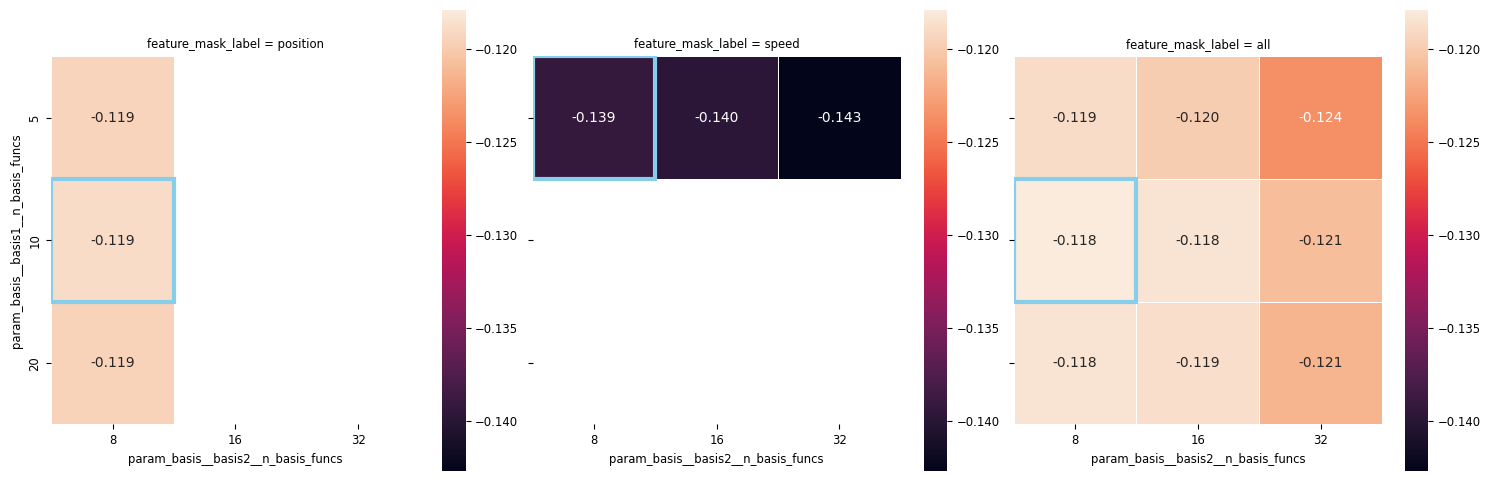

In [50]:
workshop_utils.plot_heatmap_cv_results(cv_df, "feature_mask_label", columns="param_basis__basis2__n_basis_funcs")

<div class="render-user">

- What do we see?
</div>

<div class="render-presenter">

From the above plots, we can see that:
- Position matters more than speed.
- Number of basis functions for speed doesn't matter much.
- We don't need many basis functions to represent the position.

</div>

From the above plots, we can see that:
- Position matters more than speed.
- Number of basis functions for speed doesn't matter much.
- We don't need many basis functions to represent the position.

Let's visualize the predictions of the best estimator.

<div class="render-user render-presenter">

- Visualize model predictions!

</div>

/home/agent/workspace/rorse_ccn-software-jan-2025_main/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/agent/workspace/rorse_ccn-software-jan-2025_main/lib/python3.11/site-packages/numpy/_core/_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


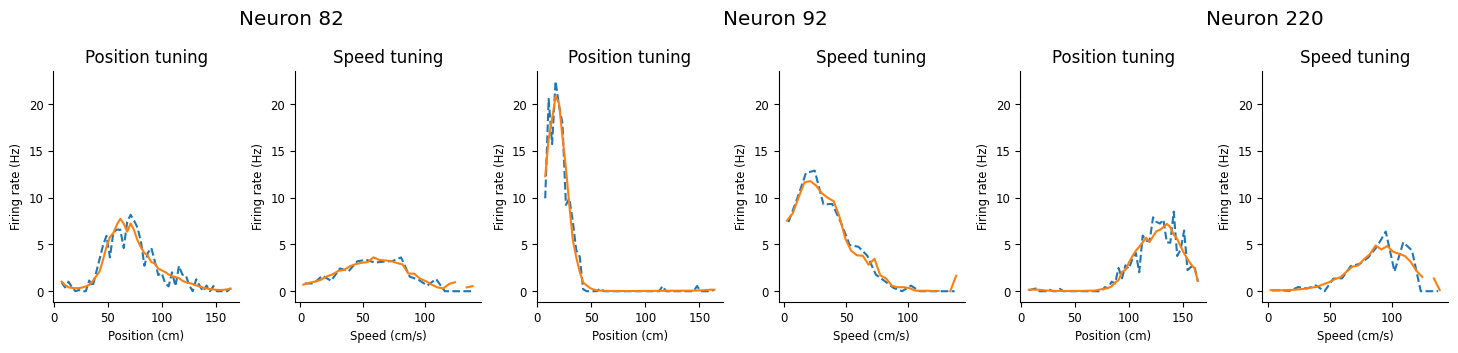

In [51]:
visualize_model_predictions(cv.best_estimator_, transformer_input)

## Conclusion

Various combinations of features can lead to different results. Feel free to explore more. To go beyond this notebook, you can check the following references :

  - [Hardcastle, Kiah, et al. "A multiplexed, heterogeneous, and adaptive code for navigation in medial entorhinal cortex." Neuron 94.2 (2017): 375-387](https://www.cell.com/neuron/pdf/S0896-6273(17)30237-4.pdf)

  - [McClain, Kathryn, et al. "Position–theta-phase model of hippocampal place cell activity applied to quantification of running speed modulation of firing rate." Proceedings of the National Academy of Sciences 116.52 (2019): 27035-27042](https://www.pnas.org/doi/abs/10.1073/pnas.1912792116)

  - [Peyrache, Adrien, Natalie Schieferstein, and Gyorgy Buzsáki. "Transformation of the head-direction signal into a spatial code." Nature communications 8.1 (2017): 1752.](https://www.nature.com/articles/s41467-017-01908-3)

## References

<div class="render-all">

The data in this tutorial comes from [Grosmark, Andres D., and György Buzsáki. "Diversity in neural firing dynamics supports both rigid and learned hippocampal sequences." Science 351.6280 (2016): 1440-1443](https://www.science.org/doi/full/10.1126/science.aad1935).

</div>